# MIMIC-IV AKI Prediction: Feature Extraction Pipeline

**Objective**: Extract features from 24h PRE-AKI for supervised classification

**Author**: June Zhang

**Date**: 2025-12-12  

**MIMIC-IV Version**: 3.1

## 1. Setup & Configuration

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import warnings
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

# ============================================================
# CONFIGURATION
# ============================================================
MIMIC_PATH = "./physionet.org/files/mimiciv/3.1"
DATA_DIR = "./prediction_output/data"
RESULT_DIR = "./prediction_output/result"
PRE_AKI_WINDOW_HOURS = 24  # Features from 24h BEFORE AKI
MIN_ICU_STAY_HOURS = 48

Path(DATA_DIR).mkdir(parents= True, exist_ok=True)
Path(RESULT_DIR).mkdir(parents= True, exist_ok=True)
print(f"✓ MIMIC path: {MIMIC_PATH}")
assert os.path.exists(MIMIC_PATH), "MIMIC path not found!"

✓ MIMIC path: ./physionet.org/files/mimiciv/3.1


## 2. Load Core Tables

In [2]:
print("Loading core tables")
print("="*60)

# ICU stays
icustays = pd.read_csv(f"{MIMIC_PATH}/icu/icustays.csv.gz", parse_dates=['intime', 'outtime'])
icustays['los_hours'] = (icustays['outtime'] - icustays['intime']).dt.total_seconds() / 3600
icustays = icustays[icustays['los_hours'] >= MIN_ICU_STAY_HOURS]
print(f"  ICU stays (≥48h): {len(icustays):,}")

# Patients
patients = pd.read_csv(f"{MIMIC_PATH}/hosp/patients.csv.gz")

# Admissions
admissions = pd.read_csv(f"{MIMIC_PATH}/hosp/admissions.csv.gz", parse_dates=['admittime', 'dischtime'])

# Creatinine labs
print("  Loading creatinine measurements")
labevents = pd.read_csv(
    f"{MIMIC_PATH}/hosp/labevents.csv.gz",
    parse_dates=['charttime'],
    usecols=['subject_id', 'hadm_id', 'charttime', 'itemid', 'valuenum']
)
cr_labs = labevents[labevents['itemid'] == 50912].copy()
print(f"  Creatinine measurements: {len(cr_labs):,}")

Loading core tables
  ICU stays (≥48h): 46,337
  Loading creatinine measurements
  Creatinine measurements: 4,319,091


## 3. Detect AKI (KDIGO Criteria)

In [3]:
print("\nDetecting AKI using KDIGO creatinine criteria")
print("="*60)

# Merge creatinine with ICU stays
cr_icu = icustays[['stay_id', 'subject_id', 'hadm_id', 'intime', 'outtime']].merge(
    cr_labs, on=['subject_id', 'hadm_id']
)

# Filter to ICU timeframe & valid values
cr_icu = cr_icu[
    (cr_icu['charttime'] >= cr_icu['intime']) &
    (cr_icu['charttime'] <= cr_icu['outtime']) &
    (cr_icu['valuenum'] > 0.1) & (cr_icu['valuenum'] < 20)
].rename(columns={'valuenum': 'creatinine'}).sort_values(['stay_id', 'charttime'])

# Calculate baseline (first Cr within 24h)
cr_icu['hours_from_admit'] = (cr_icu['charttime'] - cr_icu['intime']).dt.total_seconds() / 3600
baseline = cr_icu[cr_icu['hours_from_admit'] <= 24].groupby('stay_id')['creatinine'].first()
cr_icu = cr_icu.merge(baseline.rename('baseline_cr'), on='stay_id')

# KDIGO detection
cr_icu['cr_prev'] = cr_icu.groupby('stay_id')['creatinine'].shift()
cr_icu['time_prev'] = cr_icu.groupby('stay_id')['charttime'].shift()
cr_icu['time_diff'] = (cr_icu['charttime'] - cr_icu['time_prev']).dt.total_seconds() / 3600

# Criterion 1: ≥0.3 increase within 48h
criterion1 = (cr_icu['creatinine'] - cr_icu['cr_prev'] >= 0.3) & (cr_icu['time_diff'] <= 48)

# Criterion 2: ≥1.5× baseline
cr_icu['ratio'] = cr_icu['creatinine'] / cr_icu['baseline_cr']
criterion2 = (cr_icu['ratio'] >= 1.5) & (cr_icu['hours_from_admit'] <= 168)

cr_icu['has_aki'] = criterion1 | criterion2

# Stage
def stage(row):
    if not row['has_aki']: return 0
    r = row['ratio']
    if r >= 3.0 or row['creatinine'] >= 4.0: return 3
    if r >= 2.0: return 2
    return 1

cr_icu['aki_stage'] = cr_icu.apply(stage, axis=1)

# First AKI per stay
aki_cohort = cr_icu[cr_icu['has_aki']].groupby('stay_id').agg({
    'charttime': 'first',
    'aki_stage': 'max',
    'baseline_cr': 'first',
    'creatinine': 'first'
}).rename(columns={'charttime': 'aki_time', 'creatinine': 'aki_cr'}).reset_index()

print(f"\n✓ AKI cases: {len(aki_cohort):,}")
print(f"  Stage 1: {(aki_cohort.aki_stage==1).sum()}")
print(f"  Stage 2: {(aki_cohort.aki_stage==2).sum()}")
print(f"  Stage 3: {(aki_cohort.aki_stage==3).sum()}")


Detecting AKI using KDIGO creatinine criteria

✓ AKI cases: 13,676
  Stage 1: 7621
  Stage 2: 1634
  Stage 3: 4421


# 4. Define outcomes (labels for supervised learning)

In [4]:
print("\nDefine outcomes")
print("="*60)

# Merge with admissions for outcomes
aki_outcomes = aki_cohort.merge(
    icustays[['stay_id', 'subject_id', 'hadm_id', 'outtime']], 
    on='stay_id',
    how='left'
).merge(
    admissions[['hadm_id', 'hospital_expire_flag', 'dischtime']], 
    on='hadm_id',
    how='left'
)

# Define binary outcomes
aki_outcomes['severe_aki'] = (aki_outcomes['aki_stage'] >= 2).astype(int)
aki_outcomes['progression'] = (aki_outcomes['aki_stage'] == 3).astype(int)
aki_outcomes['mortality'] = aki_outcomes['hospital_expire_flag']

# ICU length of stay after AKI
aki_outcomes['icu_los_post_aki'] = (
    (aki_outcomes['outtime'] - aki_outcomes['aki_time']).dt.total_seconds() / 3600
)
aki_outcomes['prolonged_icu'] = (aki_outcomes['icu_los_post_aki'] > 168).astype(int)  # >7 days

print(f"\n✓ Outcome Distribution:")
print(f"  Severe AKI (Stage ≥2): {aki_outcomes['severe_aki'].sum()} ({aki_outcomes['severe_aki'].mean()*100:.1f}%)")
print(f"  AKI Progression (Stage 3): {aki_outcomes['progression'].sum()} ({aki_outcomes['progression'].mean()*100:.1f}%)")
print(f"  In-hospital Mortality: {aki_outcomes['mortality'].sum()} ({aki_outcomes['mortality'].mean()*100:.1f}%)")
print(f"  Prolonged ICU Stay: {aki_outcomes['prolonged_icu'].sum()} ({aki_outcomes['prolonged_icu'].mean()*100:.1f}%)")


Define outcomes

✓ Outcome Distribution:
  Severe AKI (Stage ≥2): 6055 (44.3%)
  AKI Progression (Stage 3): 4421 (32.3%)
  In-hospital Mortality: 3711 (27.1%)
  Prolonged ICU Stay: 3934 (28.8%)


# 5. Extract Demographics & Comorbidities

In [5]:
print("\nExtracting demographics")
print("="*60)

demo = aki_outcomes[['stay_id', 'subject_id', 'hadm_id']].merge(
    icustays[['stay_id', 'first_careunit']], on='stay_id'
).merge(
    patients[['subject_id', 'gender', 'anchor_age']], on='subject_id'
).merge(
    admissions[['hadm_id', 'race', 'admission_type', 'admission_location']], on='hadm_id'
).rename(columns={'anchor_age': 'age'})

# Comorbidities from ICD codes
print("  Extracting comorbidities")
dx = pd.read_csv(f"{MIMIC_PATH}/hosp/diagnoses_icd.csv.gz", usecols=['hadm_id', 'icd_code', 'icd_version'])
dx = dx[(dx['hadm_id'].isin(demo['hadm_id'])) & (dx['icd_version'] == 10)]

def has_dx(codes, hadm_list, prefixes):
    mask = codes['icd_code'].str.startswith(tuple(prefixes))
    matched = codes[mask]['hadm_id'].unique()
    return pd.Series([1 if h in matched else 0 for h in hadm_list], index=hadm_list)

hadm_list = demo['hadm_id'].values
comorbid = pd.DataFrame({
    'hadm_id': hadm_list,
    'chf': has_dx(dx, hadm_list, ['I50']).values,
    'hypertension': has_dx(dx, hadm_list, ['I10', 'I11', 'I12']).values,
    'diabetes': has_dx(dx, hadm_list, ['E08', 'E09', 'E10', 'E11']).values,
    'ckd': has_dx(dx, hadm_list, ['N18']).values,
    'liver_disease': has_dx(dx, hadm_list, ['K70', 'K71', 'K72', 'K73', 'K74']).values,
    'copd': has_dx(dx, hadm_list, ['J44']).values,
    'malignancy': has_dx(dx, hadm_list, ['C']).values
})

demo = demo.merge(comorbid, on='hadm_id', how='left')
print(f"✓ Demographics: {demo.shape}")


Extracting demographics
  Extracting comorbidities
✓ Demographics: (15394, 16)


# 6. Extract Vital Signs (24h pre-AKI)

In [6]:
print("\nExtracting vitals (this takes time)")
print("="*60)

VITALS = {220045: 'hr', 220052: 'map', 220181: 'map_inv', 220210: 'rr', 223761: 'temp'}

# Define PRE-AKI window
pre_aki_window = aki_outcomes[['stay_id', 'aki_time']].copy()
pre_aki_window['start'] = pre_aki_window['aki_time'] - pd.Timedelta(hours=PRE_AKI_WINDOW_HOURS)
pre_aki_window['end'] = pre_aki_window['aki_time']

vitals_list = []
for chunk in tqdm(pd.read_csv(
    f"{MIMIC_PATH}/icu/chartevents.csv.gz",
    chunksize=1_000_000,
    usecols=['stay_id', 'charttime', 'itemid', 'valuenum'],
    parse_dates=['charttime']
), desc="Chartevents"):
    chunk = chunk[(chunk['stay_id'].isin(pre_aki_window['stay_id'])) & (chunk['itemid'].isin(VITALS.keys()))]
    if len(chunk) == 0: continue
    
    chunk = chunk.merge(pre_aki_window, on='stay_id')
    # FILTER: start <= charttime < end (24h BEFORE AKI)
    chunk = chunk[(chunk['charttime'] >= chunk['start']) & (chunk['charttime'] < chunk['end'])]
    
    if len(chunk) > 0:
        vitals_list.append(chunk[['stay_id', 'itemid', 'valuenum']])

if vitals_list:
    vitals = pd.concat(vitals_list)
    vitals['vital'] = vitals['itemid'].map(VITALS)
    vitals_agg = vitals.groupby(['stay_id', 'vital'])['valuenum'].agg(['mean', 'min', 'max', 'std']).unstack()
    vitals_agg.columns = ['_'.join(col).strip() for col in vitals_agg.columns]
    vitals_agg = vitals_agg.reset_index()
    print(f"✓ Vitals: {vitals_agg.shape}")
else:
    vitals_agg = pd.DataFrame({'stay_id': aki_outcomes['stay_id']})
    print("⚠ No vitals extracted")


Extracting vitals (this takes time)


Chartevents: 433it [03:15,  2.21it/s]

✓ Vitals: (13645, 21)


# 6. Extract Labs (24h pre-AKI)

In [7]:
print("\nExtracting labs")
print("="*60)

LABS = {50912: 'cr', 51006: 'bun', 50822: 'k', 50882: 'hco3', 50813: 'lactate',
        50820: 'ph', 51222: 'hgb', 51265: 'plt', 51301: 'wbc', 50885: 'bili'}

subjects = demo['subject_id'].unique()
labs_all = labevents[(labevents['subject_id'].isin(subjects)) & (labevents['itemid'].isin(LABS.keys()))]

aki_subj = aki_outcomes[['stay_id', 'subject_id', 'aki_time']].copy()
aki_subj['start'] = aki_subj['aki_time'] - pd.Timedelta(hours=PRE_AKI_WINDOW_HOURS)
aki_subj['end'] = aki_subj['aki_time']

labs_filt = labs_all.merge(aki_subj, on='subject_id')
# FILTER: start <= charttime < end
labs_filt = labs_filt[(labs_filt['charttime'] >= labs_filt['start']) & (labs_filt['charttime'] < labs_filt['end'])]

labs_filt['lab'] = labs_filt['itemid'].map(LABS)
labs_agg = labs_filt.groupby(['stay_id', 'lab'])['valuenum'].agg(['mean', 'min', 'max']).unstack()
labs_agg.columns = ['_'.join(col).strip() for col in labs_agg.columns]
labs_agg = labs_agg.reset_index()

# BUN/Cr ratio
if 'mean_bun' in labs_agg.columns and 'mean_cr' in labs_agg.columns:
    labs_agg['bun_cr_ratio'] = labs_agg['mean_bun'] / labs_agg['mean_cr'].replace(0, np.nan)

print(f"✓ Labs: {labs_agg.shape}")


Extracting labs
✓ Labs: (12936, 32)


# 7. Merge Final Dataset

In [8]:
print("\nMerging final dataset")
print("="*60)

# Start with outcomes
final = aki_outcomes[[
    'stay_id', 'aki_time', 'aki_stage', 'baseline_cr', 'aki_cr',
    'severe_aki', 'progression', 'mortality', 'prolonged_icu'
]].copy()

# Merge features
final = final.merge(demo.drop(['subject_id', 'hadm_id'], axis=1), on='stay_id', how='left')
final = final.merge(vitals_agg, on='stay_id', how='left')
final = final.merge(labs_agg, on='stay_id', how='left')

# Feature engineering
final['cr_fold_change'] = final['aki_cr'] / final['baseline_cr']
final['cr_change_pct'] = (final['aki_cr'] - final['baseline_cr']) / final['baseline_cr'] * 100

if 'mean_hr' in final.columns and 'mean_map' in final.columns:
    final['shock_index'] = final['mean_hr'] / final['mean_map'].replace(0, np.nan)

print(f"\n✅ FINAL DATASET")
print(f"   Shape: {final.shape}")
print(f"   Patients: {len(final):,}")
print(f"   Features: {final.shape[1] - 5}")  # Subtract outcome columns
print(f"   Labels: severe_aki, progression, mortality, prolonged_icu")

# Save
final.to_csv(f"{DATA_DIR}/aki_prediction_features.csv", index=False)
print(f"\n💾 Saved to {DATA_DIR}/aki_prediction_features.csv")


Merging final dataset

✅ FINAL DATASET
   Shape: (15394, 76)
   Patients: 15,394
   Features: 71
   Labels: severe_aki, progression, mortality, prolonged_icu

💾 Saved to ./prediction_output/data/aki_prediction_features.csv


# 8. Data Quality Summary


Data quality summary

Top 15 missing features:
max_k           63.583214
min_k           63.583214
mean_k          63.583214
mean_bili       54.254905
max_bili        54.254905
min_bili        54.254905
std_map         50.214369
shock_index     49.447837
min_map         49.395869
max_map         49.395869
mean_map        49.395869
max_lactate     35.292971
min_lactate     35.292971
mean_lactate    35.292971
min_ph          26.549305
dtype: float64

Numeric features: 70
Categorical features: 5


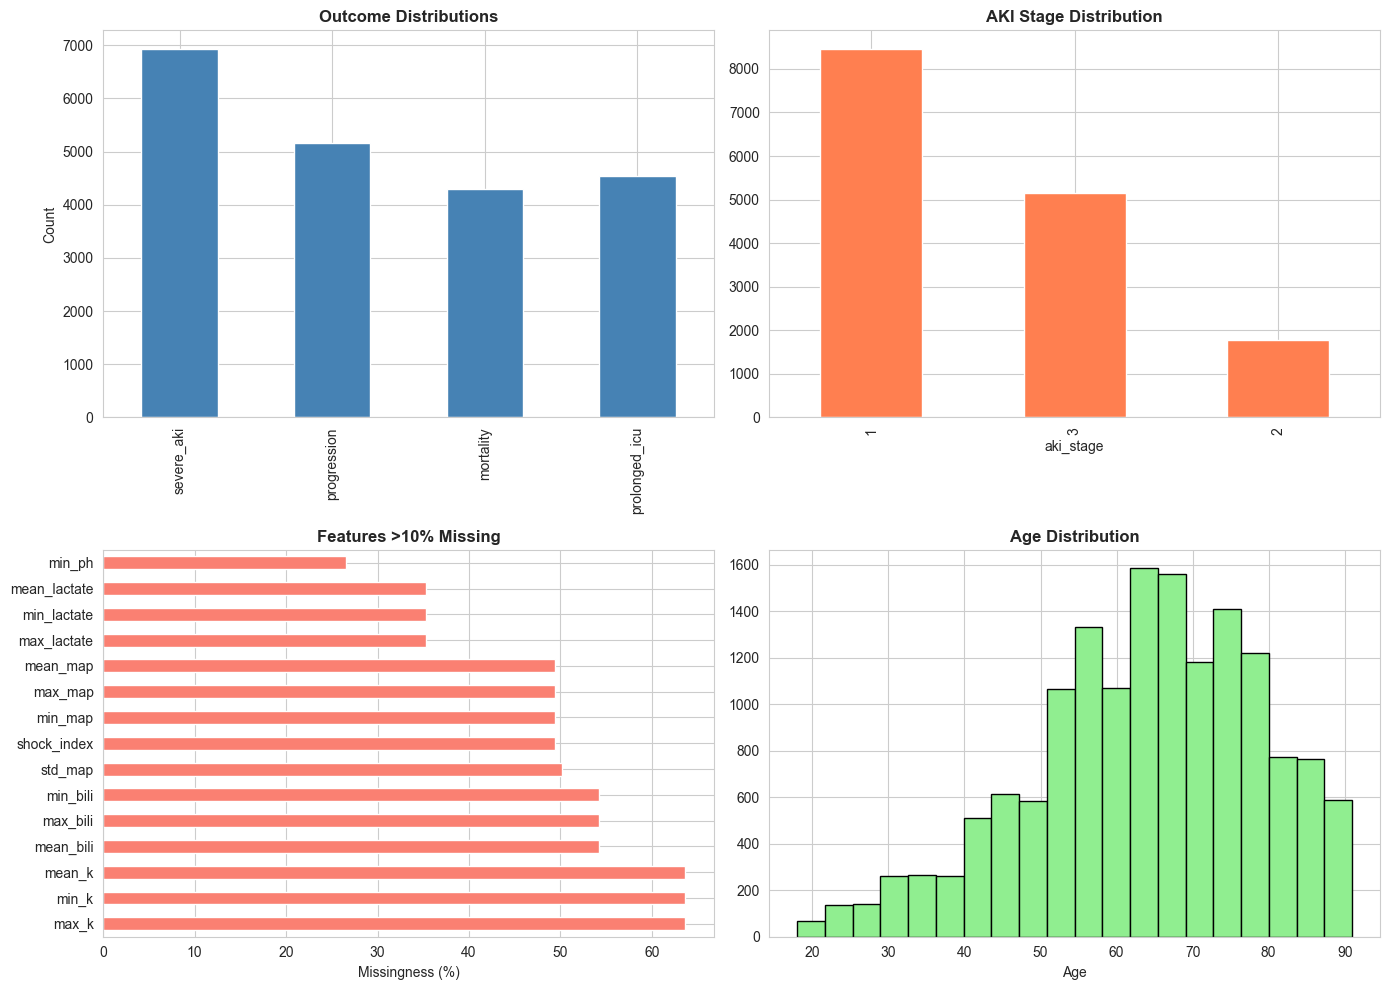


✓ Figure saved to ./prediction_output/result/prediction_data_summary.png


In [9]:
print("\nData quality summary")
print("="*60)

# Missingness
missing = (final.isnull().sum() / len(final) * 100).sort_values(ascending=False)
print("\nTop 15 missing features:")
print(missing.head(15))

# Feature types
print(f"\nNumeric features: {final.select_dtypes(include=np.number).shape[1]}")
print(f"Categorical features: {final.select_dtypes(include='object').shape[1]}")

# Visualizations
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Outcome distributions
final[['severe_aki', 'progression', 'mortality', 'prolonged_icu']].sum().plot(
    kind='bar', ax=ax[0,0], color='steelblue'
)
ax[0,0].set_title('Outcome Distributions', fontweight='bold')
ax[0,0].set_ylabel('Count')

# AKI stage
final['aki_stage'].value_counts().plot(kind='bar', ax=ax[0,1], color='coral')
ax[0,1].set_title('AKI Stage Distribution', fontweight='bold')

# Missingness
missing[missing > 10].head(15).plot(kind='barh', ax=ax[1,0], color='salmon')
ax[1,0].set_title('Features >10% Missing', fontweight='bold')
ax[1,0].set_xlabel('Missingness (%)')

# Baseline characteristics
if 'age' in final.columns:
    final['age'].hist(ax=ax[1,1], bins=20, color='lightgreen', edgecolor='black')
    ax[1,1].set_title('Age Distribution', fontweight='bold')
    ax[1,1].set_xlabel('Age')

plt.tight_layout()
plt.savefig(f"{RESULT_DIR}/prediction_data_summary.png", dpi=300)
plt.show()

print(f"\n✓ Figure saved to {RESULT_DIR}/prediction_data_summary.png")

In [10]:
print("✅ DATA EXTRACTION COMPLETE!")
print("="*60)

✅ DATA EXTRACTION COMPLETE!
